In [1]:
import msprime # used to generate datasets
import tskit
import numba
import numpy as np
import matplotlib.pyplot as plt
import time

`tskit`'s contributors are diverse and prolific! We are actively working on new features, bug fixes, and improvements to the usability of existing features. Here's a shortlist of some recent additions:

### Reference sequences

By default, the sites in a tree sequence only define the nucleotide types at the genomic positions where polymorphism is observed. The nucleotides at remaining positions can now be filled using the `TreeSequence.reference_sequence` , and individual sample alignments can be obtained with the new `TreeSequence.alignments()` iterator.

### Structural operations

We've expanded the set of utility functions for large edits on tree sequences. For instance, the `TreeSequence.decapitate` method removes all parts of a tree sequence that are older than some user-specified time.

### Efficient array access 

The relationships between nodes in each tree can now be extracted as `numpy` arrays. When used in conjunction with `numba`, it is possible to perform Python-based calculations on the trees that run as speedily as machine-level code. Consider these calculations of total branch length on trees of different sizes:

In [2]:
ts = msprime.sim_ancestry( # Tree
            samples=5e5,
            sequence_length=1e6,
            random_seed=720,
            population_size = 10000
)
ts

In [3]:
sizes = [1e3, 1e4, 1e5, 1e6]
runtime_dict = {}

In [4]:
# Using Python and existing tskit tree methods
runtime = []
for size in sizes:
    if size < 1e6:
        ts0 = ts.simplify([i for i in range(int(size))])
    else:
        ts0 = ts

    time_sum = 0
    for pos in range(0, 1_000_000, 200_000):
        t = ts0.at(pos)
        # Time
        time_start = time.time()
        sum(t.branch_length(u) for u in t.nodes())
        time_end = time.time()
        time_sum += time_end - time_start
    runtime.append(time_sum/5)
                           
runtime_dict['python'] = runtime    

In [5]:
# Using tskit's inbuilt method (coded in C)
runtime = []
for size in sizes:
    if size < 1e6:
        ts0 = ts.simplify([i for i in range(int(size))])
    else:
        ts0 = ts
        
    time_sum = 0
    for pos in range(0, 1_000_000, 200_000):
        t = ts0.at(pos)
        # Time
        time_start = time.time()
        t.total_branch_length
        time_end = time.time()
        time_sum += time_end - time_start
    runtime.append(time_sum/5)
                           
runtime_dict['tskit'] = runtime  

In [6]:
# Numba functions using parent_array
@numba.njit
def _total_branch_length(preorder, parent, node_time):
     tbl = 0
     for u in preorder:
          if parent[u] != -1:
               tbl += node_time[parent[u]] - node_time[u]
     return tbl

def get_total_branch_length(tree):
     return _total_branch_length(tree.preorder(), tree.parent_array, tree.tree_sequence.nodes_time)

# need to 'preheat' the function before timing it
get_total_branch_length(t)

587726.2722671757

In [7]:
# Using numba
runtime = []
for size in sizes:
    if size < 1e6:
        ts0 = ts.simplify([i for i in range(int(size))])
    else:
        ts0 = ts
        
    time_sum = 0
    for pos in range(0, 1_000_000, 200_000):
        t = ts0.at(pos)
        # Time
        time_start = time.time()
        get_total_branch_length(t)
        time_end = time.time()
        time_sum += time_end - time_start
    runtime.append(time_sum/5)
                           
runtime_dict['numba'] = runtime  

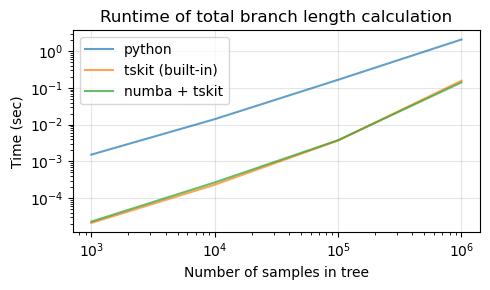

In [13]:
fig, ax = plt.subplots(1, figsize=(5, 3))
ax.grid(axis='y', color='grey', alpha=0.2)
ax.grid(axis='x', color='grey', alpha=0.2)
ax.plot(sizes, runtime_dict['python'], label='python', alpha=0.7)
ax.plot(sizes, runtime_dict['tskit'], label='tskit (built-in)', alpha=0.7)
ax.plot(sizes, runtime_dict['numba'], label='numba + tskit', alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Runtime of total branch length calculation")
ax.set_xlabel("Number of samples in tree")
ax.set_ylabel("Time (sec)")
ax.legend()
plt.tight_layout()
fig.savefig("images/numba_runtime.pdf")